In [69]:
import matplotlib.pyplot as plt
import string
import pandas as pd
import re
from io import StringIO
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
import time
import pickle
import plotly.express as px
from nltk.tokenize import sent_tokenize

## Keywords

In [144]:
elf_keywords = [
    "elf", "elves", "elvish", "legolas", "thranduil", "woodland realm", "elvenking", "mirkwood", "elrond", 
    "galadriel", "lothlorien", "rivendell", "grey havens", "undying lands", "glorfindel", "arwen", "celeborn", 
    "haldir"
]

men_keywords = [
    "men", "race of men", "man", "aragorn", "strider", "elessar", "boromir", "denethor", "faramir", "eowyn", 
    "eomer", "theoden", "grima wormtongue", "barliman butterbur", "bard", "girion", "imrahil", "isildur", "anarion", 
    "elendil", "arnor", "rohan", "riddermark", "edoras", "helm hammerhand", "gamling", "elfhelm", "erkenbrand", 
    "helms deep", "westfold", "east emnet", "eastfold", "gondor", "minas tirith", "osgiliath", "dol amroth", 
    "pelargir", "bree", "eriador", "prancing pony", "fornost", "weathertop", "amon sul", "amon hen", "lake town", 
    "esgaroth", "dale", "rangers of the north", "ithilien", "beornings", "woodsman", "hama", "beregond", 
    "halbarad", "hirgon", "duinhir", "forlong", "damrod", "mablung", "dunharrow", "harad", "haradrim", "umbar", 
    "cair andros", "easterlings", "numenor", "numenoreans", "eorl"
]

dwarf_keywords = [
    "dwarf", "gimli", "gloin", "thorin oakenshield", "lonely mountain", "erebor", "dain", "king under the mountain", 
    "arkenstone", "iron hills", "moria", "khazad dum", "dwarrowdelf", "blue mountains", "balin", "dwalin", "fili", 
    "kili", "dori", "nori", "ori", "oin", "bifur", "bofur", "bombur", "mithril", "durins folk", "mazarbul", 
    "azanulbizar", "mirrormere", "durin"]

goblin_orc_keywords = [
    "misty mountains", "goblin town", "goblin", "goblins", "the great goblin", "orc", "orcs", "orcish", "azog", 
    "bolg", "gorbag", "shagrat", "grishnákh", "uglúk", "uruk-hai", "uruk hai", "uruks", "uruk", "snaga", "mordor", "isengard", 
    "moria", "cirith ungol", "minas morgul", "angband", "barad-dûr", "dark tower"]

goblin_keywords = [
    'goblin town', 'goblin', 'goblins', 'the great goblin', 'azog', 'bolg']

ent_keywords = [
    "ent", "entwives", "huorns", "tree", "trees", "old man willow", "quickbeam", "beechbone", "fangorn", "forest", 
    "old forest", "mirkwood", "isengard", "entmoot", "march of the ents", "entwives", "skinbark", "entish", 
    "leaflock", "fladrif", "finglas", "branch", "twig", "leaf", "leaves", "wellinghall", "mallorn", "party tree", 
    "derndingle", "greenwood", "onodrim", "entwash", "entwife", "methedras", "treebeards hill"]

hobbit_keywords = [
    "hobbit", "hobbits", "Frodo Baggins", "Samwise", "Sam", "Meriadoc", "Brandybuck", "Merry", "Peregrin", "Pippin", 
    "Bilbo Baggins", "Rosie Cotton", "Gaffer", "Lobelia", "Otho", "Lotho", "Fatty Bolger", "Ted Sandyman", "Baggins", 
    "Took", "Brandybuck", "Gamgee", "Sackville-Baggins", "Farmer Maggot", "The Shire", "Shirefolk", "Hobbiton", 
    "Bag End", "Bywater", "Buckland", "Brandy Hall", "Tuckborough", "Green Dragon Inn", "The Ivy Bush", "Michel Delving", 
    "Lockholes", "Frogmorton", "Crickhollow", "Great Smials", "Bagshot Row", "Woody End", "westfarthing", "north farthing", 
    "south farthing", "longbottom", "golden perch", "stock", "whitwell", "old took"]

troll_keywords = [
    "troll", "trolls", "william", "bill huggins", "tom", "bert", "stone-trolls", "trollshaws", "troll-hole", "troll-caves", 
    "cave-troll", "olog-hai"]

spider_keywords = [
    "spider", "spiders", "shelob", "webs", "spider webs", "spiderwebs", "mirkwood", "ungoliant"]

ringwraith_keywords = [
    "ringwraith", "witch-king", "angmar", "wraith", "nazgul", "fell beast", "necromancer", "necromancers", "Sauron", 
    "Dol Guldur", "morgul-blade", "minas morgul", "mordor", "nine", "black riders", "servants of sauron"]

Think I will remove apostrophes and other items of punctuation.
Need to determine how and where sentences are broken.
Focus on impersonal nouns (e.g. house, axe, ring), verbs, adverbs, and adjectives.

### File Paths

In [71]:
hobbit_file_path = ('Resources/00 - Hobbit_or_There_and_Back_Again.txt')
fellowship_file_path = ('Resources/01 - The Fellowship Of The Ring.txt')
towers_file_path = ('Resources/02 - The Two Towers.txt')
return_file_path = ('Resources/03 - The Return Of The King.txt')

### Functions

In [72]:
def read_book(file_path):
    # Try opening the file with utf-8 encoding
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read().lower()
    except UnicodeDecodeError:
        # If utf-8 fails, try another common encoding like ISO-8859-1
        with open(file_path, 'r', encoding='ISO-8859-1') as file:
            return file.read().lower()

In [ ]:
def preprocess_text(text):
    translator = str.maketrans('','', string.punctuation)
    return text.translate(translator).split()

def get_word_length(words):
    return [len(word) for word in words if word.isalpha()]

In [ ]:
# Function to load the text file and split into paragraphs using multiple delimiters
def load_text_to_dataframe(file_path):
    # Read the entire text file
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # Use regular expression to split the text by '\n\n' or '***'
    # The pattern '(\n\n|\*\*\*)' matches either '\n\n' or '***'
    paragraphs = re.split(r'(\n\n|\*\*\*)', text)
    # Filter out any empty or unwanted delimiters in paragraphs
    paragraphs = [para.strip() for para in paragraphs if para.strip() and para not in ['\n\n', '***']]
    df = pd.DataFrame(paragraphs, columns=['Paragraph']) # Create a DataFrame
    return df

def sentences_to_dataframe(text):
    sentences = sent_tokenize(text)
    df = pd.DataFrame(sentences, columns=['Sentence']) # Create a DataFrame
    return df

In [ ]:
def filter_paragraphs(df, keywords):
    # Use the DataFrame's `.apply()` method with a lambda function to check each paragraph
    keywords = [keyword.lower() for keyword in keywords]
    # The lambda function will check if any keyword is in the paragraph
    filtered_df = df[df['Paragraph'].apply(lambda x: any(keyword in x for keyword in keywords))]
    return filtered_df

In [73]:
def filter_sentences(df, keywords):
    # Use the DataFrame's `.apply()` method with a lambda function to check each paragraph
    keywords = [keyword.lower() for keyword in keywords]
    # The lambda function will check if any keyword is in the paragraph
    filtered_df = df[df['Sentence'].apply(lambda x: any(keyword in x for keyword in keywords))]
    return filtered_df

In [ ]:
models = ["en_core_web_sm", "en_core_web_md"]
nlp = spacy.load("en_core_web_sm")

def cleantext(text):
    text = re.sub(r"\s+", " ", text).strip()
    doc = nlp(text)

    total_tokens = len(doc)
    processed_tokens = 0
    filtered_tokens = []

    for token in doc:
        if token.text.lower() not in STOP_WORDS and not token.is_punct:
            filtered_tokens.append(token.lemma_)

    return filtered_tokens, doc

In [ ]:
def key_phrase_extraction(tokens, n=1):
    n_grams = zip(*[tokens[i:] for i in range(n)])
    n_grams = [" ".join(ngram) for ngram in n_grams]
    frequency = Counter(n_grams)
    N = 20
    key_phrases = frequency.most_common(N)
    df = pd.DataFrame(key_phrases, columns=["Phrase", "Count"])
    plt.figure(figsize=(8, 6))
    plt.bar(df['Phrase'], df['Count'], color='skyblue', edgecolor='black')
    plt.xticks(rotation=45)
    plt.title('Bar chart of N-grams')
    plt.xlabel('Phrase')
    plt.ylabel('Count')
    plt.show()
    return df

Note for later: remove chapter headings

In [74]:
hobbit_text = read_book(hobbit_file_path)

hobbit_sentences = sentences_to_dataframe(hobbit_text)
hobbit_sentences.head()

,Sentence
0,chapter one\n\n\n\nan unexpected party\n\n\n\n...
1,"not a nasty, dirty, wet hole, filled with the ..."
2,"it had a perfectly round door like a porthole,..."
3,the door opened on to a tube-shaped hall like ...
4,"the tunnel wound on and on, going fairly but n..."


In [75]:
goblin_sentences_df = filter_sentences(hobbit_sentences, goblin_keywords)
goblin_sentences_df.head()

,Sentence
163,"he had only just had a sip - in the corner, wh..."
304,he charged the ranks of the goblins of mount g...
600,the master of the house was an elf-friend - on...
615,they were made in gondolin for the goblin-wars.
616,"this, thorin, is named orcrist, the goblin-cle..."


In [76]:
hobbit_df = load_text_to_dataframe(hobbit_file_path)
hobbit_df.head()

,Paragraph
0,CHAPTER ONE
1,An Unexpected Party
2,In a hole in the ground there lived a hobbit. ...
3,"It had a perfectly round door like a porthole,..."
4,"This hobbit was a very well-to-do hobbit, and ..."


## Goblins

In [78]:
goblin_keywords = ['goblin town', 'goblin', 'goblins', 'the great goblin', 'azog', 'bolg']

goblins_para_df = filter_paragraphs(hobbit_df, goblin_keywords)
goblins_para_df

,Paragraph
45,"""Throng!"" thought Mr. Baggins. ""I don't like t..."
99,"If you have ever seen a dragon in a pinch, you..."
197,The master of the house was an elf-friend - on...
202,"Thorin pondered these words. ""I will keep this..."
230,"Out jumped the goblins, big goblins, great ugl..."
...,...
1089,He sat up painfully. Looking into the valley h...
1105,"All that had happened after he was stunned, Bi..."
1107,The roar of his voice was like drums and guns;...
1128,He had many hardships and adventures before he...


In [79]:
goblin_para_text = " ".join(goblins_para_df['Paragraph'].astype(str))
goblin_sent_text = " ".join(goblin_sentences_df['Sentence'].astype(str))

In [97]:
cleaned_goblins_tokens, cleaned_goblins_doc = cleantext(goblin_para_text)

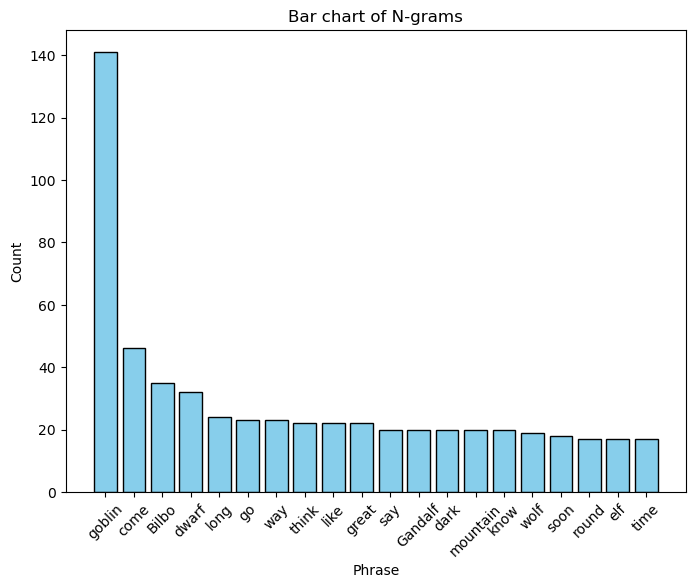

,Phrase,Count
0,goblin,141
1,come,46
2,Bilbo,35
3,dwarf,32
4,long,24
5,go,23
6,way,23
7,think,22
8,like,22
9,great,22


In [98]:
key_phrase_extraction(cleaned_goblins_tokens, n=1)

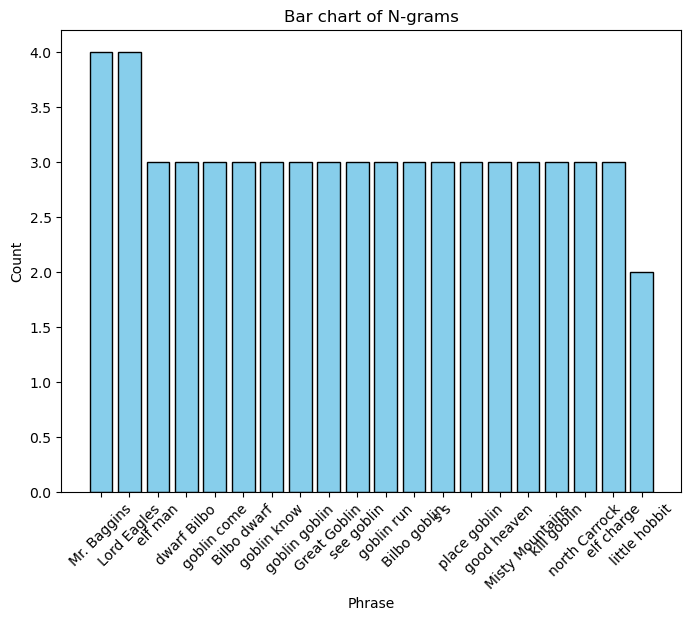

,Phrase,Count
0,Mr. Baggins,4
1,Lord Eagles,4
2,elf man,3
3,dwarf Bilbo,3
4,goblin come,3
5,Bilbo dwarf,3
6,goblin know,3
7,goblin goblin,3
8,Great Goblin,3
9,see goblin,3


In [99]:
key_phrase_extraction(cleaned_goblins_tokens, n=2)

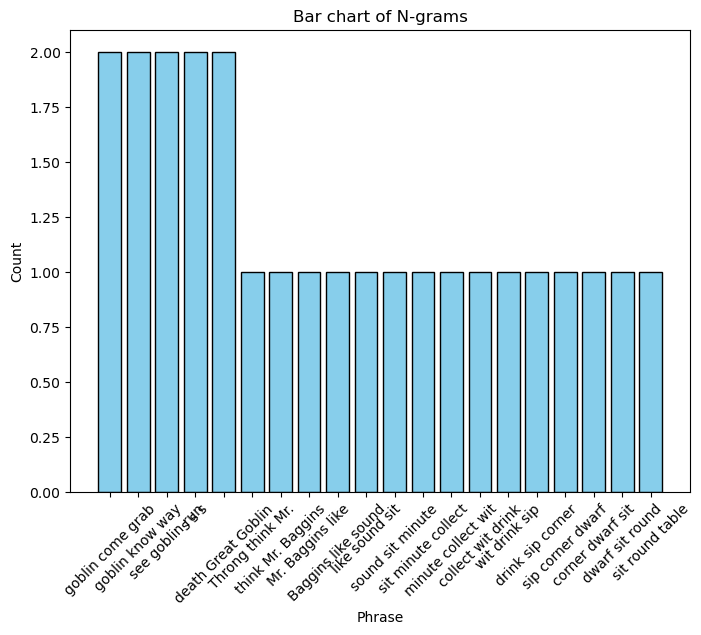

,Phrase,Count
0,goblin come grab,2
1,goblin know way,2
2,see goblin run,2
3,s s s,2
4,death Great Goblin,2
5,Throng think Mr.,1
6,think Mr. Baggins,1
7,Mr. Baggins like,1
8,Baggins like sound,1
9,like sound sit,1


In [100]:
key_phrase_extraction(cleaned_goblins_tokens, n=3)

In [101]:
cleaned_goblins_tokens, cleaned_goblins_doc = cleantext(goblin_sent_text)

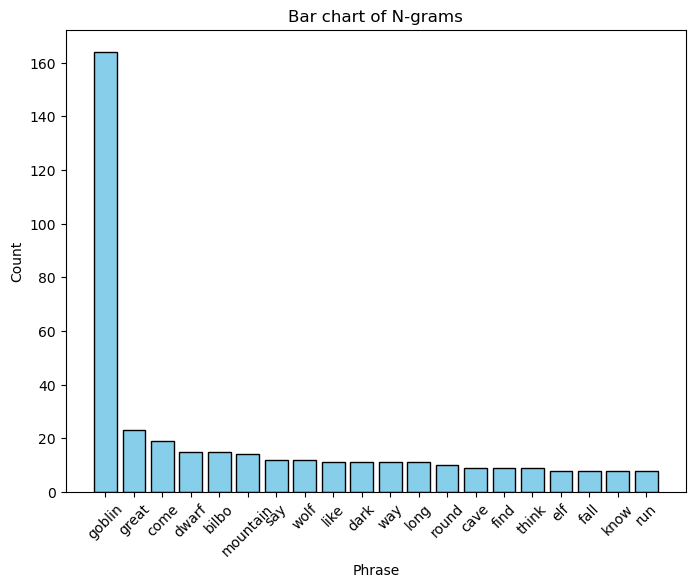

,Phrase,Count
0,goblin,164
1,great,23
2,come,19
3,dwarf,15
4,bilbo,15
5,mountain,14
6,say,12
7,wolf,12
8,like,11
9,dark,11


In [102]:
key_phrase_extraction(cleaned_goblins_tokens, n=1)

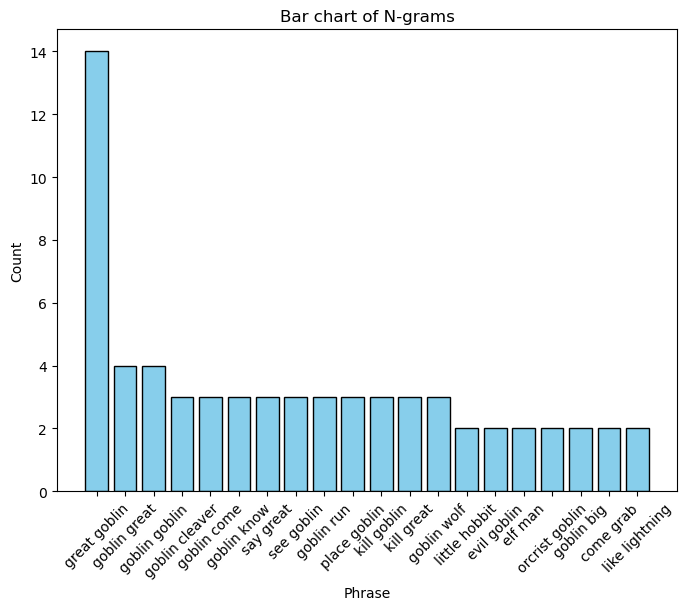

,Phrase,Count
0,great goblin,14
1,goblin great,4
2,goblin goblin,4
3,goblin cleaver,3
4,goblin come,3
5,goblin know,3
6,say great,3
7,see goblin,3
8,goblin run,3
9,place goblin,3


In [103]:
key_phrase_extraction(cleaned_goblins_tokens, n=2)

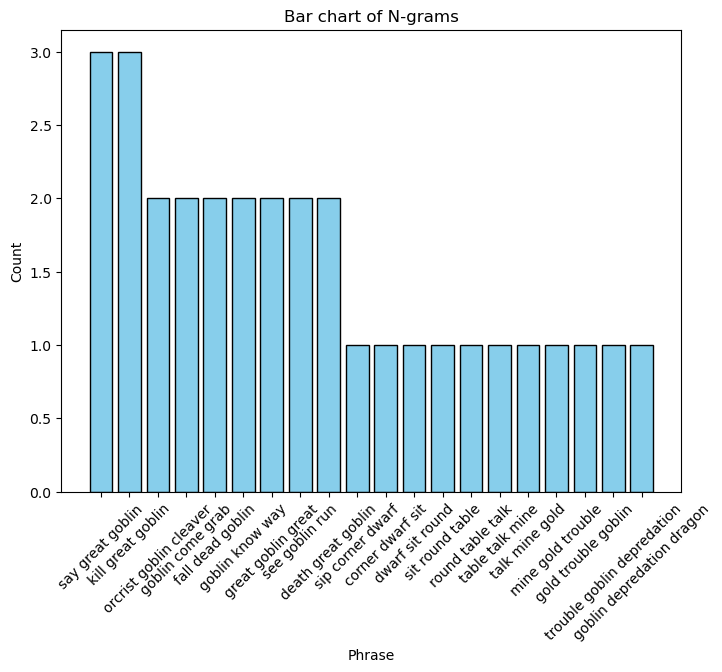

,Phrase,Count
0,say great goblin,3
1,kill great goblin,3
2,orcrist goblin cleaver,2
3,goblin come grab,2
4,fall dead goblin,2
5,goblin know way,2
6,great goblin great,2
7,see goblin run,2
8,death great goblin,2
9,sip corner dwarf,1


In [104]:
key_phrase_extraction(cleaned_goblins_tokens, n=3)

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer 

documents = goblin_sent_text.split(". ")

vectorizer = TfidfVectorizer(stop_words='english')

tfidf_matrix = vectorizer.fit_transform(documents)

feature_names = vectorizer.get_feature_names_out()

dense_tfidf_matrix = tfidf_matrix.todense()

df_tfidf = pd.DataFrame(dense_tfidf_matrix, columns=feature_names)

df_tfidf

,able,adventurous,afoot,afraid,ages,ago,agree,air,ajar,alive,...,worn,worst,wound,wounded,yammered,yelled,yelling,yells,yelping,yes
0,0.0,0.180865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
average_scores = df_tfidf.sum().sort_values(ascending=False)
average_scores.head(30)

goblins      16.009145
bilbo         8.742947
goblin        6.983514
did           6.944140
gandalf       6.233058
came          6.141455
said          5.892865
dwarves       5.851498
great         5.439078
like          5.363821
long          4.981867
thought       4.764573
time          4.556274
dark          4.474998
mountains     4.408803
far           4.385804
way           4.264924
come          4.110123
eyes          3.926803
soon          3.922235
elves         3.791586
round         3.714166
sword         3.639493
wolves        3.632647
good          3.525071
things        3.449829
door          3.404725
went          3.380826
going         3.354370
heard         3.310239
dtype: float64

In [141]:
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

def get_top_tfidf_words(df, top_n=3):
    top_words_dict = {}
    for i, row in df.iterrows():
        top_words = row.sort_values(ascending=False).head(top_n).index.tolist()
        top_words_dict[f'Sentence {i+1}'] = top_words
    return top_words_dict

top_tfidf_words = get_top_tfidf_words(df_tfidf)
top_tfidf_words

{'Sentence 1': ['throng', 'mr', 'thought'],
 'Sentence 2': ['baggins', 'able', 'redoubled'],
 'Sentence 3': ['sound', 'don', 'like'],
 'Sentence 4': ['did', 'sit', 'dragons'],
 'Sentence 5': ['hobbit', 'poetical', 'exaggeration'],
 'Sentence 6': ['gram', 'ranks', 'clean'],
 'Sentence 7': ['rabbit', 'sailed', 'won'],
 'Sentence 8': ['history', 'wars', 'evil'],
 'Sentence 9': ['ancestors', 'elrond', 'heroes'],
 'Sentence 10': ['words', 'pondered', 'thorin'],
 'Sentence 11': ['honour', 'sword', 'said'],
 'Sentence 12': ['goblins', 'cleave', 'blocks'],
 'Sentence 13': ['flint', 'tinder', 'carried'],
 'Sentence 14': ['gandalf', 'able', 'red'],
 'Sentence 15': ['yell', 'good', 'bilbo'],
 'Sentence 16': ['like', 'splintered', 'gunpowder'],
 'Sentence 17': ['snap', 'wait', 'wrong'],
 'Sentence 18': ['seized', 'hurried', 'dwarves'],
 'Sentence 19': ['deep', 'taken', 'heart'],
 'Sentence 20': ['unmercifully', 'crossed', 'tangled'],
 'Sentence 21': ['wished', 'hole', 'nice'],
 'Sentence 22': ['ti

#### I want to find out what adjectives, nouns, verbs are most associated with goblins. Then, I want to find out what are uniquely associated with goblins, as opposed to other races.

## Hobbits